In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader, Dataset
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime
from tqdm import tqdm  # For progress bar
from torch.amp import autocast, GradScaler  # Mixed Precision Training
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from HSI_class import HSI
import VGG as vgg
import createSample as CS
import augmentation as aug



# Check if GPU is available
print("GPU Available:", torch.cuda.is_available())

# If available, print the GPU name
if torch.cuda.is_available():
    print("GPU Name:", torch.cuda.get_device_name(0))


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

GPU Available: True
GPU Name: NVIDIA GeForce GTX 1650


In [2]:
dataset_path = "Hyperspectral oil spill detection datasets"

dataset = []

i = 0
for filename in os.listdir(dataset_path):
    if i > 0:
        break
    file_path = os.path.join(dataset_path, filename)
    if os.path.isfile(file_path):  # Check if it's a file
        print(f"Processing file: {file_path}")
        hsi = HSI(file_path)
        dataset.append(hsi)
    i += 1

Processing file: Hyperspectral oil spill detection datasets\GM01.mat


In [3]:
for hsi in dataset:
    print(f'{hsi.name}: {hsi.img.shape}')

GM01: (1243, 684, 224)


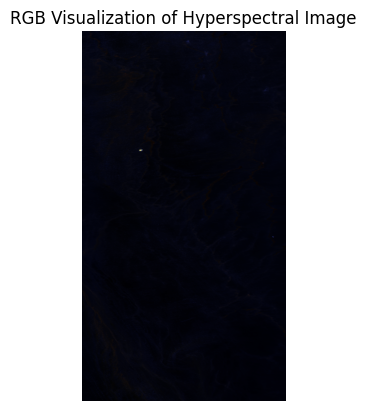

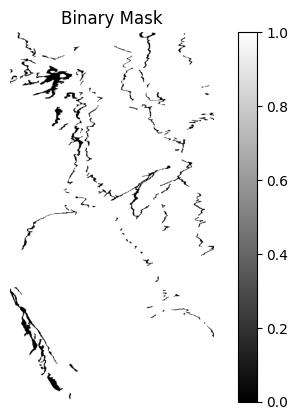

In [4]:
img = dataset[0].img
gt = dataset[0].gt
r_band = 31  # Red (around 660 nm) https://www.indexdatabase.de/db/s-single.php?id=28
g_band = 22  # Green (around 560 nm)
b_band = 10 # Blue (around 450 nm)

red_band = img[:, :, r_band]  # Adjust band index for red
green_band = img[:, :, g_band]  # Adjust band index for green
blue_band = img[:, :, b_band]  # Adjust band index for blue

# Normalize bands to range 0-1 for proper visualization
red_band = (red_band - np.min(red_band)) / (np.max(red_band) - np.min(red_band))
green_band = (green_band - np.min(green_band)) / (np.max(green_band) - np.min(green_band))
blue_band = (blue_band - np.min(blue_band)) / (np.max(blue_band) - np.min(blue_band))

rgb_image = np.stack((red_band, green_band, blue_band), axis=-1)

# Display the RGB image
plt.imshow(rgb_image)
plt.title("RGB Visualization of Hyperspectral Image")
plt.axis('off')
plt.show()

# Visualize the binary mask
plt.imshow(1 - gt, cmap='gray')  # Use 'gray' for binary visualization
plt.colorbar()
plt.title('Binary Mask')
plt.axis('off')
plt.show()

In [5]:
hsi_ = dataset[0]
patch_size = 9
sample_per_class = 5
selected_patch_0, selected_patch_1, random_indices_0, random_indices_1 = CS.createSample(hsi_, patch_size, sample_per_class)

print(f"selected patch 0: {selected_patch_0.shape}")
print(f"selected patch 1: {selected_patch_1.shape}")

print(random_indices_0)
print(random_indices_1)

hsi shape
(1243, 684, 224)
creating 5 Randomly chosen 0 indices:
creating 5 Randomly chosen 1 indices:
selected patch 0: (5, 9, 9, 224)
selected patch 1: (5, 9, 9, 224)
[(np.int64(1029), np.int64(11)), (np.int64(739), np.int64(449)), (np.int64(519), np.int64(332)), (np.int64(813), np.int64(171)), (np.int64(806), np.int64(140))]
[(np.int64(84), np.int64(462)), (np.int64(969), np.int64(67)), (np.int64(134), np.int64(244)), (np.int64(130), np.int64(153)), (np.int64(346), np.int64(211))]


In [6]:
i =4
half_patch = patch_size // 2
print(hsi_.img[random_indices_0[i][0]][random_indices_0[i][1]])
print(selected_patch_0[i][half_patch][half_patch])

print(hsi_.img[random_indices_1[i][0]][random_indices_1[i][1]])
print(selected_patch_1[i][half_patch][half_patch])

[-203 -500  225  333  379  518  608  608  580  546  514  470  441  401
  365  348  314  292  274  240  214  191  169  144  126  115  101   94
   83   78   75   71   73   65   60   45   34   29   20  -23   10   20
   30   -7   13   21   16   13   12  -15   -7    0   20   17   18   14
   13   -6  -15  -19  -16  -84 -114 -105  -18   -7    4   11   12   13
   13   11   13   13   15    6    3    2  -11  -37 -106 -107 -134 -115
  -53  -14   -7   -7   -9  -12   -5    0    3    8    7    7    7   14
   11    7   10   -7   -9   70  -38  -87 -124    0    0    0    0    0
    0  -88  -37  -73  -75  -76  -86  -61  -25   -9    0    6    4    9
   13    8   11   14    8   14    4   10    9   12   12    7    9    7
    5   10    9   11    3    1    1  -10   -8  -11  -50  -59  -32    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
  -13   -9   -9   -8   -7  -18  -20  -16   -8    0    4    0    8    3
    0    3    3    0    7    1    2    7    9    1   -1    0    0    8
    0 

In [7]:
indices = random_indices_0 +  random_indices_1

# Concatenating along axis 0
x_train = np.concatenate((selected_patch_0, selected_patch_1), )

y_train = np.array([])

gt = hsi_.gt
for indice in indices:
    # print(gt[indice[0]][indice[1]])
    y_train = np.append(y_train, gt[indice[0]][indice[1]])

count = np.count_nonzero(y_train == 0)  # Count elements equal to 0
print(f'number of element equal 0 {count}')

count = np.count_nonzero(y_train == 1)  # Count elements equal to 1
print(f'number of element equal 1 {count}')


# print(y_train) 


# Print shape to verify
print(f"x_train shape: {x_train.shape}")  # Expected output: (10, 9, 9, 224)
print(f"y_train shape: {y_train.shape}") 


number of element equal 0 5
number of element equal 1 5
x_train shape: (10, 9, 9, 224)
y_train shape: (10,)


In [8]:
# Augmentation
n_category = 2
band_size = 224
num_per_category = 50

data_augment1, label_augment1 = aug.Augment_data(x_train, y_train, n_category, patch_size, band_size, num_per_category)

data_augment2, label_augment2 = aug.Augment_data2(x_train, y_train, n_category, patch_size, band_size, 200)

print(f"hasil augmentasi 1 shape: {data_augment1.shape}")
print(f"label augmentai 1 shape: {label_augment1.shape}")

print(f"hasil augmentasi 2 shape: {data_augment2.shape}")
print(f"label augmentasi 2 shape: {label_augment2.shape}")

# print(label_augment1)
# print(label_augment2)

# Count occurrences of each unique element
counts1 = np.bincount(label_augment1)

# Print results
for i, count in enumerate(counts1):
    print(f"Element {i} occurs {count} times.")

counts2 = np.bincount(label_augment2)

# Print results
for i, count in enumerate(counts2):
    print(f"Element {i} occurs {count} times.")

j:  100
hasil augmentasi 1 shape: (100, 9, 9, 224)
label augmentai 1 shape: (100,)
hasil augmentasi 2 shape: (400, 9, 9, 224)
label augmentasi 2 shape: (400,)
Element 0 occurs 50 times.
Element 1 occurs 50 times.
Element 0 occurs 200 times.
Element 1 occurs 200 times.


In [10]:
data_augment = np.concatenate((data_augment1, data_augment2))
label_augment = np.concatenate((label_augment1, label_augment2))

print(f"hasil augmentasi gabungan untuk training: {data_augment.shape}")
print(f"label augmentasi gabungan: {label_augment.shape}")

# print(label_augment)

# Count occurrences of each unique element
counts = np.bincount(label_augment)

# Print results
for i, count in enumerate(counts):
    print(f"Element {i} occurs {count} times.")

hasil augmentasi gabungan untuk training: (500, 9, 9, 224)
label augmentasi gabungan: (500,)
Element 0 occurs 250 times.
Element 1 occurs 250 times.


In [11]:
# Example usage
print("creating model...")
model = vgg.VGG16_HSI()
print("model created")

print(model)

creating model...


c:\Users\Asus TUF\Documents\code\TA\myenv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Asus TUF\Documents\code\TA\myenv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


model created
VGG16_HSI(
  (pre_conv): Sequential(
    (0): Conv2d(224, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): AdaptiveAvgPool2d(output_size=(1, 1))
  )
  (fc): Linear(in_features=256, out_features=200704, bias=True)
  (vgg): VGG(
    (features): Sequential(
      (0): ReLU(inplace=True)
      (1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (5): ReLU(inplace=True)
      (6): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): ReLU(

In [12]:
test = data_augment[0]
test = torch.tensor(test)
test = test.to(torch.float32)
test = test.unsqueeze(0)

input = test
input = input.permute(0, 3, 1, 2)

print(f"input shape: {input.shape}")

# Pass the input through the model
output = model(input)

# Print the output shape
print("Output Shape:", output.shape)

output_value = output.detach().numpy() 
print(f"output value: {output_value}")

input shape: torch.Size([1, 224, 9, 9])
Output Shape: torch.Size([1, 2])
output value: [[0.42376012 0.46382317]]


In [13]:
X_train = data_augment
X_train = torch.tensor(X_train)
X_train = X_train.to(torch.float32)
X_train = X_train.permute(0, 3, 1, 2)
print(f"X_train shape: {X_train.shape}")

y_train = torch.tensor(label_augment)

print(f"y_train shape: {y_train.shape}")


X_train shape: torch.Size([500, 224, 9, 9])
y_train shape: torch.Size([500])


In [ ]:
# # Generate validation data
# hsi_val = dataset[1]
# patch_size = 9
# sample_per_class = 100
# selected_patch_0, selected_patch_1, random_indices_0, random_indices_1 = CS.createSample(hsi_val, patch_size, sample_per_class)

# i =12
# half_patch = patch_size // 2
# print(hsi_val.img[random_indices_0[i][0]][random_indices_0[i][1]])
# print(selected_patch_0[i][half_patch][half_patch])

# print(hsi_val.img[random_indices_1[i][0]][random_indices_1[i][1]])
# print(selected_patch_1[i][half_patch][half_patch])

# indices = random_indices_0 + random_indices_1


# # Concatenating along axis 0
# X_val = np.concatenate((selected_patch_0, selected_patch_1), axis=0)
# # Print shape to verify
# X_val = torch.tensor(X_val)
# X_val = X_val.to(torch.float32)
# X_val = X_val.permute(0, 3, 1, 2)
# print(f"x_val shape: {X_val.shape}")  # Expected output: (10, 9, 9, 224)


# y_val = np.array([])

# gt = hsi_val.gt
# for indice in indices:
#     # print(gt[indice[0]][indice[1]])
#     y_val = np.append(y_val, gt[indice[0]][indice[1]])

# count = np.count_nonzero(y_val == 0)  # Count elements equal to 0
# print(f"jumlah kelas 0: {count}")

# count = np.count_nonzero(y_val == 1)  # Count elements equal to 1
# print(f"jumlah kelas 1: {count}")

# y_val = torch.tensor(y_val)
# y_val = y_val.to(torch.long)
# # print(y_val)
# print(f"y_val shape: {y_val.shape}") 



In [20]:
# create combination
n = len(X_train)
combination = []
for i in range(n-1):
    for j in range(i+1, n):
        combination.append((i, j))

print(len(combination))

124750


In [22]:
# Custom Dataset Class
# 1 same class
# 0 different class
class CustomDataset(Dataset):
    def __init__(self, data, labels, combinations):
        self.data = data
        self.labels = labels
        self.combinations = combinations


    def __len__(self):
        return len(self.combinations)

    def __getitem__(self, idx):
        data1_indice = self.combinations[idx][0]
        data2_indice = self.combinations[idx][1]

        data1_label = self.labels[data1_indice]
        data2_label = self.labels[data2_indice]

        if data1_label == data2_label:
            # positive
            pair = 1
        else:
            # negative
            pair = 0
        
        return self.data[data1_indice], self.data[data2_indice], pair
    

In [ ]:
# train_dataset = CustomDataset(X_train, y_train, combination)
# for i in range(1000):
#     img1, img2, pair = train_dataset.__getitem__(i)
#     print(f"{i}: {pair}")



In [42]:
# Create separate datasets
train_dataset = CustomDataset(X_train, y_train, combination)



# Create DataLoaders
batch_size = 50
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

i = 0
for images, image2, labels in train_loader:
    i += 1
    # print(f"{i}: Validation Batch - images shape: {images.shape}, labels shape: {labels.shape}")
    # break
print(f"jumlah training batch: {i}")




jumlah training batch: 2495


In [43]:
def contrastive_loss(output1, output2, label, temperature=0.07):
    # Normalize the embeddings
    output1 = F.normalize(output1, dim=-1)
    output2 = F.normalize(output2, dim=-1)

    # Compute similarity
    similarity = torch.matmul(output1, output2.T) / temperature

    # Mask out negative pairs based on the label
    positive_mask = label.bool()
    negative_mask = ~positive_mask

    # Positive similarity
    positive_similarity = similarity[positive_mask]

    # Negative similarity
    negative_similarity = similarity[negative_mask]

    # Compute InfoNCE loss
    positive_loss = -torch.log(torch.exp(positive_similarity) / (torch.exp(positive_similarity) + torch.sum(torch.exp(negative_similarity))))
    loss = positive_loss.mean()

    return loss


In [44]:
# Initialize Model
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [45]:
def train_model(model, train_loader, optimizer, epochs=5):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")
        for img1, img2, label in progress_bar:
            img1, img2, label = img1.to(device), img2.to(device), label.to(device)
            optimizer.zero_grad()
            output1, output2 = model(img1), model(img2)
            loss = contrastive_loss(output1, output2, label)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            progress_bar.set_postfix(loss=total_loss / (len(train_loader) + 1))
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {total_loss/len(train_loader):.4f}")

In [46]:
# Train the model
train_model(model, train_loader, optimizer)

Epoch 1/5: 100%|██████████| 2495/2495 [36:51<00:00,  1.13it/s, loss=nan]   


Epoch [1/5], Loss: nan


Epoch 2/5: 100%|██████████| 2495/2495 [36:46<00:00,  1.13it/s, loss=nan] 


Epoch [2/5], Loss: nan


Epoch 3/5:  11%|█         | 279/2495 [04:06<32:34,  1.13it/s, loss=nan]  


KeyboardInterrupt: 

In [ ]:
# Generate validation data
hsi_test = dataset[2]
patch_size = 9
sample_per_class = 500
selected_patch_0, selected_patch_1, random_indices_0, random_indices_1 = CS.createSample(hsi_test, patch_size, sample_per_class)

In [ ]:
i =12
half_patch = patch_size // 2
print(hsi_test.img[random_indices_0[i][0]][random_indices_0[i][1]])
print(selected_patch_0[i][half_patch][half_patch])

print(hsi_test.img[random_indices_1[i][0]][random_indices_1[i][1]])
print(selected_patch_1[i][half_patch][half_patch])

In [ ]:
indices = random_indices_0 + random_indices_1


# Concatenating along axis 0
X_test = np.concatenate((selected_patch_0, selected_patch_1), axis=0)
# Print shape to verify
X_test = torch.tensor(X_test)
X_test = X_test.to(torch.float32)
X_test = X_test.permute(0, 3, 1, 2)
print(f"test shape: {X_test.shape}")  # Expected output: (10, 9, 9, 224)

y_test = np.array([])

gt = hsi_test.gt
for indice in indices:
    # print(gt[indice[0]][indice[1]])
    y_test = np.append(y_test, gt[indice[0]][indice[1]])

count = np.count_nonzero(y_test == 0)  # Count elements equal to 0
print(f"jumlah kelas 0: {count}")

count = np.count_nonzero(y_test == 1)  # Count elements equal to 1
print(f"jumlah kelas 1: {count}")

y_test = torch.tensor(y_test)
y_test = y_test.to(torch.long)
# print(y_test)
print(f"y_test shape: {y_test.shape}") 

In [ ]:
test_dataset = CustomDataset(X_test, y_test)

batch_size = 10
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

i = 0
for images, image2, labels in test_loader:
    i += 1
    # print(f"{i}: Validation Batch - images shape: {images.shape}, labels shape: {labels.shape}")
    # break
print(f"jumlah testing batch: {i}")

In [ ]:
evaluate_model(model, test_loader)

In [ ]:
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')

model_path = './models/contrastive/model_{}_{}'.format(timestamp, "latest")
torch.save(model.state_dict(), model_path)

In [ ]:
# total = 0
# correct = 0

# prediction_arr = np.full((height, width), -1)

# max1 = 10
# max2 = 10
# break_flag = 0
# for i in range(height):
#     if i >= max1:
#         break
    
#     for j in range(width):
#         if j > max2:
#             print("break")
#             # break_flag = 1
#             break
#         x_pos = i
#         y_pos = j
#         selected_rows = matrix[range(x_pos,x_pos+2*half_patch+1), :]
#         testing_patch = selected_rows[:, range(y_pos, y_pos+2*half_patch+1)]

      

#         # print(f"{i},{j}: testing patch, seed pixel on data hsi")
#         # print(testing_patch[half_patch][half_patch])
#         # print(test_img[i][j])

#         testing_patch = torch.tensor(testing_patch)
#         testing_patch = testing_patch.to(torch.float32)
#         testing_patch = testing_patch.unsqueeze(0)
#         testing_patch = testing_patch.permute(0, 3, 1, 2)

#         prediction, confidence = predict(testing_patch)

#         prediction_arr[i][j] = prediction

#         true_label = test_gt[i][j]

#         print(f"{i}, {j}: {testing_patch.shape}: {prediction}, {confidence}, expecteed class: {true_label}")

#         if(prediction == true_label):
#             correct += 1

#         total += 1

# print(f"{correct}/{total}")
# print({i},{j})

In [ ]:
# print(prediction_arr)
# print(prediction_arr.shape)

In [ ]:
# count = np.count_nonzero(test_gt == 0)  # Count elements equal to 0
# print(f"jumlah kelas 0: {count}")

# count = np.count_nonzero(test_gt == 1)  # Count elements equal to 1
# print(f"jumlah kelas 1: {count}")

# new_array = test_gt[:500, :500]
# print(new_array.shape)
# count = np.count_nonzero(new_array == 0)  # Count elements equal to 0
# print(f"jumlah kelas 0: {count}")

# count = np.count_nonzero(new_array == 1)  # Count elements equal to 1
# print(f"jumlah kelas 1: {count}")

# ones_indices = np.argwhere(new_array == 1)
# print(ones_indices)

In [ ]:
# print(test_gt[370][499])